In [1]:
import pickle
import numpy as np
import pandas as pd
from knn import KNN
from svm import SVM
import seaborn as sns
import matplotlib.pyplot as plt
from rf import clasificar_datos
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
scaler = StandardScaler()

# Crear un objeto LabelEncoder
le = LabelEncoder()

In [3]:
# Cargar los modelos desde los archivos pickle
with open('RF.pkl', 'rb') as file:
    loaded_model, loaded_counter = pickle.load(file)
    print("Modelo y contador cargados desde 'RF.pkl'")
    # Ahora puedes usar 'loaded_model' en lugar de 'forest' y 'loaded_counter' en lugar de 'contador'
    forest = loaded_model
    contador = loaded_counter

with open('KNN.pkl', 'rb') as file:
    knn = pickle.load(file)
    print("Modelo cargado desde 'KNN.pkl'")

with open('SVM2.pkl', 'rb') as file:
    svm = pickle.load(file)
    print("Modelo cargado desde 'SVM.pkl'")

Modelo y contador cargados desde 'RF.pkl'
Modelo cargado desde 'KNN.pkl'
Modelo cargado desde 'SVM.pkl'


In [4]:
df = pd.read_csv('muestras/concatenado.csv')

In [5]:
# Obtener las etiquetas verdaderas de los datos
y_true = df['Tipo de Archivo'].tolist()

In [6]:
# La columna "Tipo de Archivo" es la etiqueta
testLabels = df["Tipo de Archivo"].values

# El resto son las características
testFeatures = df.drop("Tipo de Archivo", axis=1).values

In [7]:
# Ajustar el escalador a los datos de prueba
scaler.fit(testFeatures)

StandardScaler()

In [8]:
# Escalar los datos de prueba con el mismo escalador que se usó para los datos de entrenamiento
testFeatures = scaler.transform(testFeatures)

In [9]:
# Ajustar el LabelEncoder a los datos
le.fit(y_true)

LabelEncoder()

In [10]:
y_true_encoded = le.transform(y_true)

In [11]:
predictions = []
for i in range(len(df)):
    # Hacer una predicción con cada árbol
    tree_predictions = [clasificar_datos(df.iloc[i,:], tree) for tree in forest]
    
    # Usar la votación para obtener la predicción final
    obs_pred = max(set(tree_predictions), key=tree_predictions.count)
    
    predictions.append(obs_pred)
    

In [12]:
def printMetricas(actual, predictions):
    assert len(actual) == len(predictions)
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predictions[i]:
            correct += 1
    return (correct / float(len(actual)) * 100.0)

In [13]:
accuracy = accuracy_score(y_true_encoded, predictions)
precision = precision_score(y_true_encoded, predictions)
recall = recall_score(y_true_encoded, predictions)
f1 = f1_score(y_true_encoded, predictions)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy:  0.9992526315789474
Precision:  0.999200084201663
Recall:  0.9993052631578947
F1 Score:  0.9992526709120573


In [14]:
# Realiza las predicciones en el conjunto de prueba
prediccion = knn.prediccion(testFeatures)

# Calcula la precisión
accuracy = printMetricas(testLabels, prediccion)
print('Accuracy:', accuracy)

Accuracy: 89.51473684210526


In [15]:
# Usar la función para hacer predicciones con tu lista de modelos
y_pred_svm = svm.predict(testFeatures)

In [16]:
y_pred_svm[y_pred_svm == -1] = 0


In [17]:
accuracy = accuracy_score(y_true_encoded, y_pred_svm)

# Calcular la precisión
print(f"Accuracy: ", accuracy)

Accuracy:  0.5685263157894737


In [18]:
# Calcula las métricas de rendimiento para cada modelo
report_rf = classification_report(y_true_encoded, predictions, output_dict=True)
report_knn = classification_report(testLabels, prediccion, output_dict=True)
report_svm = classification_report(y_true_encoded, y_pred_svm, output_dict=True)

In [19]:
df_rf = pd.DataFrame(report_rf).transpose()
df_knn = pd.DataFrame(report_knn).transpose()
df_svm = pd.DataFrame(report_svm).transpose()

In [20]:
# Imprime las tablas de métricas de rendimiento
print('Métricas de rendimiento para el modelo RF:')
print(df_rf)

print('\nMétricas de rendimiento para el modelo KNN:')
print(df_knn)

print('\nMétricas de rendimiento para el modelo KNN:')
print(df_svm)

Métricas de rendimiento para el modelo RF:
              precision    recall  f1-score       support
0              0.999305  0.999200  0.999253  47500.000000
1              0.999200  0.999305  0.999253  47500.000000
accuracy       0.999253  0.999253  0.999253      0.999253
macro avg      0.999253  0.999253  0.999253  95000.000000
weighted avg   0.999253  0.999253  0.999253  95000.000000

Métricas de rendimiento para el modelo KNN:
              precision    recall  f1-score       support
benigno        0.882419  0.911789  0.896864  47500.000000
ransomware     0.908752  0.878505  0.893373  47500.000000
accuracy       0.895147  0.895147  0.895147      0.895147
macro avg      0.895586  0.895147  0.895118  95000.000000
weighted avg   0.895586  0.895147  0.895118  95000.000000

Métricas de rendimiento para el modelo KNN:
              precision    recall  f1-score       support
0              0.590896  0.445474  0.507982  47500.000000
1              0.554992  0.691579  0.615803  47500.0000

In [21]:
# Calcula la matriz de confusión para el modelo RF
conf_matrix_rf = confusion_matrix(y_true_encoded, predictions)

# Calcula la matriz de confusión para el modelo KNN
conf_matrix_knn = confusion_matrix(testLabels, prediccion)

# Calcula la matriz de confusión para el modelo RF
conf_matrix_svm = confusion_matrix(y_true_encoded, y_pred_svm)

In [22]:
class_labels = ['Benigno', 'Ransomware']

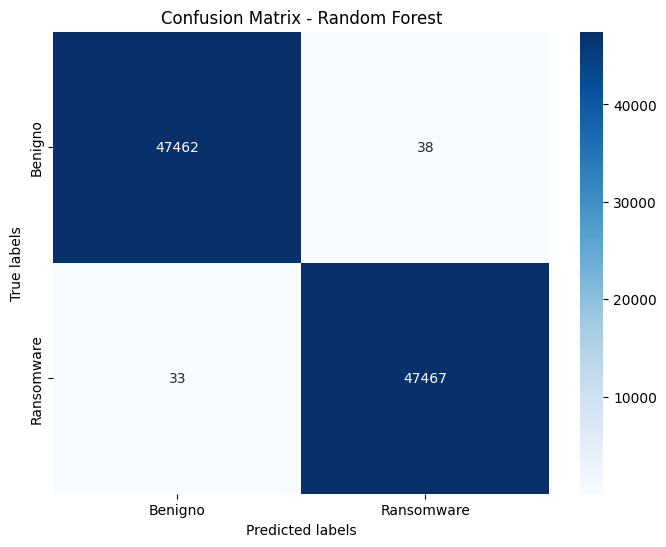

In [23]:
# Visualiza la matriz de confusión para el modelo RF
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()


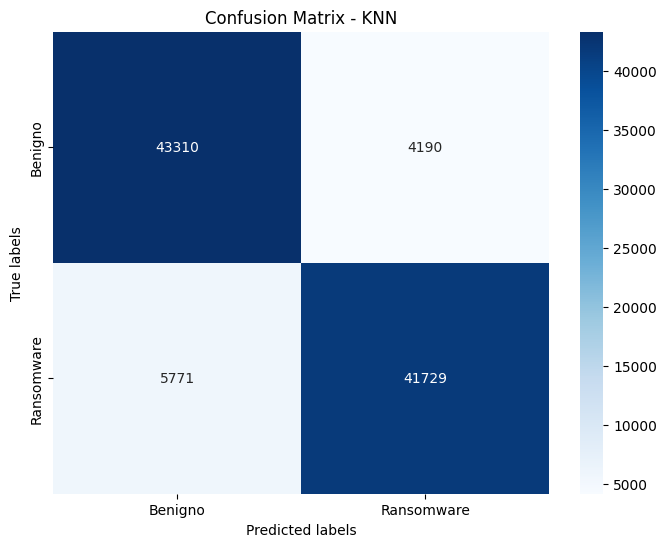

In [24]:
# Visualiza la matriz de confusión para el modelo KNN
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - KNN')
plt.show()

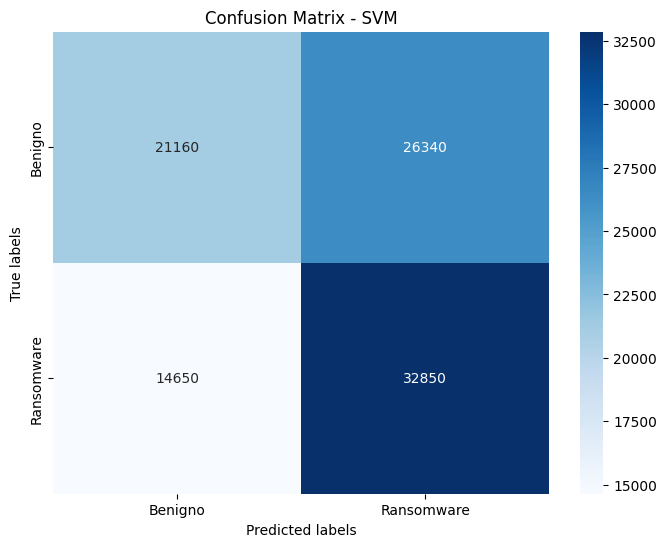

In [25]:
# Visualiza la matriz de confusión para el modelo RF
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - SVM')
plt.show()


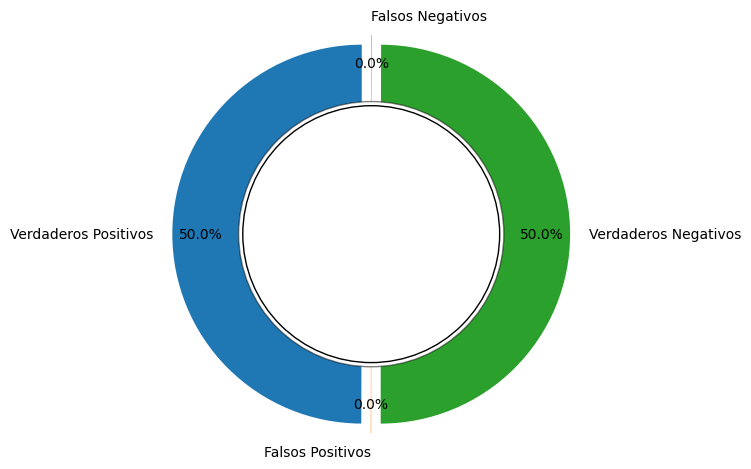

In [26]:
# Calcula el número total de predicciones
total_predictions = np.sum(conf_matrix_rf)

# Calcula el número de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos
tp = conf_matrix_rf[0, 0]
fp = conf_matrix_rf[0, 1]
tn = conf_matrix_rf[1, 1]
fn = conf_matrix_rf[1, 0]

# Crea una lista con los valores
values = [tp, fp, tn, fn]

# Crea una lista con las etiquetas
labels = ['Verdaderos Positivos', 'Falsos Positivos', 'Verdaderos Negativos', 'Falsos Negativos']

# Crea el gráfico de dona
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = (0.05, 0.05, 0.05, 0.05))

# Dibuja un círculo blanco en el centro
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Añade sombras para un efecto 3D
ax.add_artist(plt.Circle((0, 0), 0.70, fc='white', linewidth=1, edgecolor='black', fill=True, alpha = 0.5))
ax.add_artist(plt.Circle((0, 0), 0.678, fc='white', linewidth=1, edgecolor='black', fill=True, alpha = 1))

# Iguala la relación de aspecto para asegurar que la tarta se dibuje como un círculo
ax.axis('equal')  
plt.tight_layout()
plt.show()

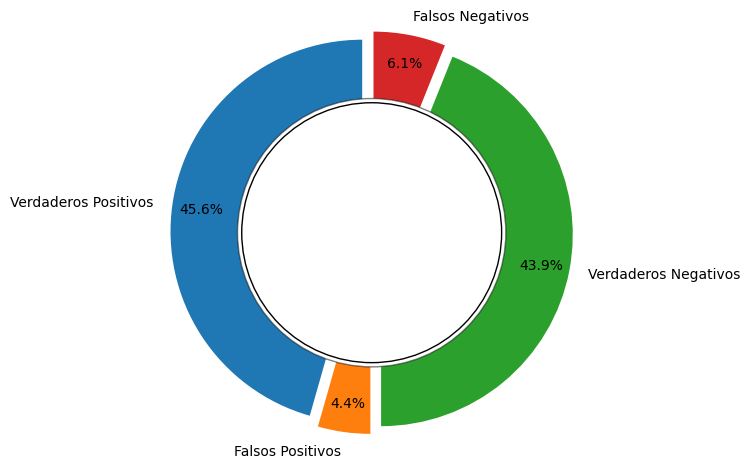

In [30]:
# Calcula el número total de predicciones
total_predictions = np.sum(conf_matrix_knn)

# Calcula el número de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos
tp = conf_matrix_knn[0, 0]
fp = conf_matrix_knn[0, 1]
tn = conf_matrix_knn[1, 1]
fn = conf_matrix_knn[1, 0]

# Crea una lista con los valores
values = [tp, fp, tn, fn]

# Crea una lista con las etiquetas
labels = ['Verdaderos Positivos', 'Falsos Positivos', 'Verdaderos Negativos', 'Falsos Negativos']

# Crea el gráfico de dona
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = (0.05, 0.05, 0.05, 0.05))

# Dibuja un círculo blanco en el centro
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Añade sombras para un efecto 3D
ax.add_artist(plt.Circle((0, 0), 0.70, fc='white', linewidth=1, edgecolor='black', fill=True, alpha = 0.5))
ax.add_artist(plt.Circle((0, 0), 0.678, fc='white', linewidth=1, edgecolor='black', fill=True, alpha = 1))

# Iguala la relación de aspecto para asegurar que la tarta se dibuje como un círculo
ax.axis('equal')  
plt.tight_layout()
plt.show()

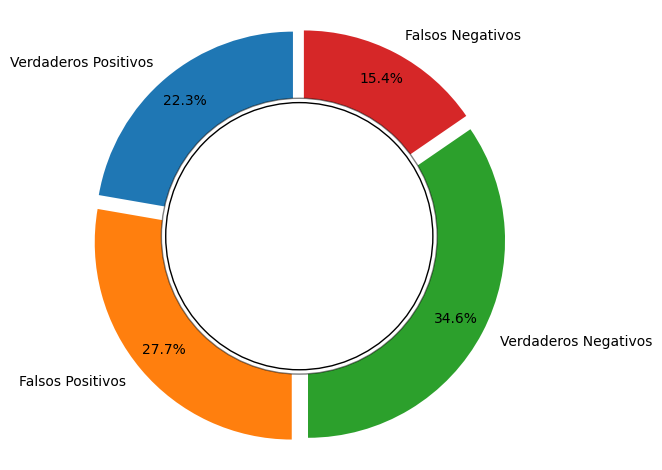

In [31]:
# Calcula el número total de predicciones
total_predictions = np.sum(conf_matrix_svm)

# Calcula el número de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos
tp = conf_matrix_svm[0, 0]
fp = conf_matrix_svm[0, 1]
tn = conf_matrix_svm[1, 1]
fn = conf_matrix_svm[1, 0]

# Crea una lista con los valores
values = [tp, fp, tn, fn]

# Crea una lista con las etiquetas
labels = ['Verdaderos Positivos', 'Falsos Positivos', 'Verdaderos Negativos', 'Falsos Negativos']

# Crea el gráfico de dona
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = (0.05, 0.05, 0.05, 0.05))

# Dibuja un círculo blanco en el centro
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Añade sombras para un efecto 3D
ax.add_artist(plt.Circle((0, 0), 0.70, fc='white', linewidth=1, edgecolor='black', fill=True, alpha = 0.5))
ax.add_artist(plt.Circle((0, 0), 0.678, fc='white', linewidth=1, edgecolor='black', fill=True, alpha = 1))

# Iguala la relación de aspecto para asegurar que la tarta se dibuje como un círculo
ax.axis('equal')  
plt.tight_layout()
plt.show()

ValueError: y_true takes value in {'benigno', 'ransomware'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

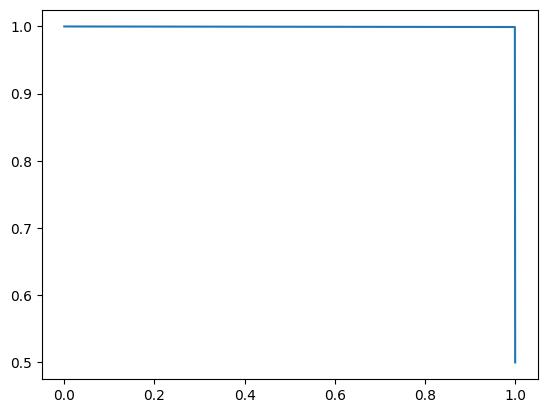

In [29]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Para Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_true_encoded, predictions)
plt.plot(recall_rf, precision_rf, label='RF')

# Para KNN
#testLabels = le.transform(testLabels)
#prediccion = le.transform(prediccion)
precision_knn, recall_knn, _ = precision_recall_curve(testLabels, prediccion)
plt.plot(recall_knn, precision_knn, label='KNN')

# Para SVM
# y_pred_svm = le.transform(y_pred_svm)

precision_svm, recall_svm, _ = precision_recall_curve(y_true_encoded, y_pred_svm)
plt.plot(recall_svm, precision_svm, label='SVM')

# Configurar el gráfico
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall para RF, KNN Y SVM')

# Establece los ticks en el eje y
plt.yticks(np.arange(0.5, 1.01, 0.025))

# Establece los ticks en el eje y
plt.xticks(np.arange(0.0, 1.01, 0.1))

plt.legend()
plt.show()